In [ ]:
aimport pandas as pd
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
import tensorflow as tf
from PIL import Image, ImageEnhance
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import  img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from sklearn.metrics import classification_report,confusion_matrix
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/External Images.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/CS-06 MANGO DISEASE DETECTOR DATASET.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
folder_names = ["Anthracnose"  , "Die Black" , "Gall Midge" , "Healthy",
             "Powdery Mildew"  , "Sooty Mould"]
data_dir = Path("/content/CS-06 MANGO DISEASE DETECTOR DATASET")

In [ ]:
def filter_subdirs(subdirs):
    return [subdir for subdir in subdirs if Path(subdir).name in folder_names]

In [ ]:
def count_images_per_class(folder_names, data_dir):
    class_counts = {}
    for folder in folder_names:
        class_path = data_dir / folder
        num_images = len(list(class_path.glob('*.jpg')))  # assuming the images are in jpg format
        class_counts[folder] = num_images
    return class_counts

In [ ]:
class_counts = count_images_per_class(folder_names, data_dir)
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])

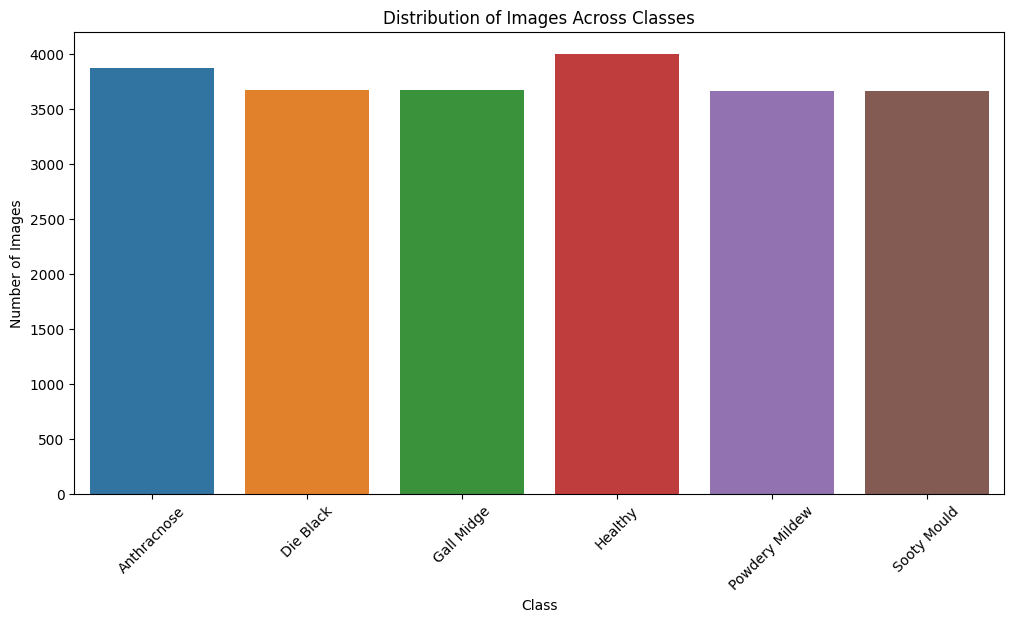

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=class_counts_df.reset_index(), x='index', y='count')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45)
plt.show()

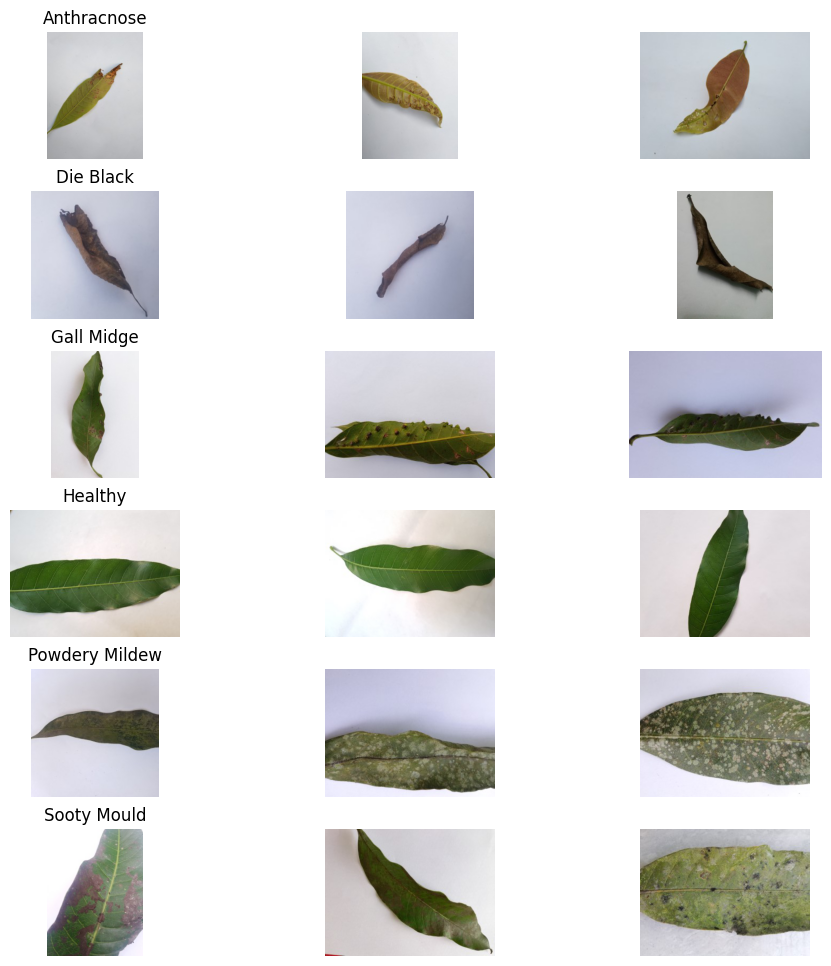

In [ ]:
def display_sample_images(folder_names, data_dir, num_samples=3):
    fig, axes = plt.subplots(len(folder_names), num_samples, figsize=(12, 2 * len(folder_names)))

    for i, folder in enumerate(folder_names):
        class_path = data_dir / folder
        image_files = list(class_path.glob('*.jpg'))
        samples = random.sample(image_files, num_samples)

        for j, image_file in enumerate(samples):
            img = Image.open(image_file)
            axes[i, j].imshow(img)
            axes[i, j].set_axis_off()

            if j == 0:
                axes[i, j].set_title(folder)

    plt.subplots_adjust(wspace=0.05, hspace=0.25)
    plt.show()

display_sample_images(folder_names, data_dir)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to your train, validation, and test folders
train_dir = '/content/CS-06 MANGO DISEASE DETECTOR DATASET'
val_dir = '/content/CS-06 MANGO DISEASE DETECTOR DATASET'
test_dir = '/content/External Images'

# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

# Data Augmentation and Preprocessing
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generating train dataset
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generating validation dataset
val_generator = data_generator.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Generating test dataset (without augmentation)
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# # Model training
# model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.n // batch_size,
#     epochs=10,
#     validation_data=val_generator,
#     validation_steps=val_generator.n // batch_size
# )

# # Model evaluation
# test_loss, test_accuracy = model.evaluate(test_generator)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)


Found 22533 images belonging to 6 classes.
Found 22533 images belonging to 6 classes.
Found 293 images belonging to 6 classes.


In [ ]:
#Number of classes in your dataset
num_classes = 6

# Load the pre-trained InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your own top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint(filepath = "./FYP.h5",
                     monitor = "accuracy",
                     verbose = 1,
                     save_best_only = True)

es= EarlyStopping(monitor = "accuracy",
                  min_delta = 0.01,
                  patience=5,
                  verbose =1)
cb = [mc,es]
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks = cb
)

Epoch 1/10
704/704 [==============================] - ETA: 0s - loss: 0.1849 - accuracy: 0.9398
Epoch 1: accuracy improved from -inf to 0.93982, saving model to ./FYP.h5
704/704 [==============================] - 639s 887ms/step - loss: 0.1849 - accuracy: 0.9398 - val_loss: 0.0857 - val_accuracy: 0.9718
Epoch 2/10
704/704 [==============================] - ETA: 0s - loss: 0.0743 - accuracy: 0.9744
Epoch 2: accuracy improved from 0.93982 to 0.97436, saving model to ./FYP.h5
704/704 [==============================] - 621s 883ms/step - loss: 0.0743 - accuracy: 0.9744 - val_loss: 0.0530 - val_accuracy: 0.9805
Epoch 3/10
704/704 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9834
Epoch 3: accuracy improved from 0.97436 to 0.98338, saving model to ./FYP.h5
704/704 [==============================] - 598s 849ms/step - loss: 0.0517 - accuracy: 0.9834 - val_loss: 0.0495 - val_accuracy: 0.9832
Epoch 4/10
704/704 [==============================] - ETA: 0s - loss: 0.0522 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

10/10 [==============================] - 5s 496ms/step - loss: 0.4756 - accuracy: 0.9181
Test Loss: 0.4756232798099518
Test Accuracy: 0.9180887341499329


In [ ]:
from tensorflow.keras.models import save_model
save_path = '/content/drive/MyDrive/CS-06 Model.h5'
save_model(model, save_path)

In [ ]:
predicted_labels = model.predict(test_generator)
y_pred = np.argmax(predicted_labels, axis=1)
y_true = test_generator.classes
correct_predictions = np.sum(y_true == y_pred)
total_predictions = len(y_true)
accuracy = (correct_predictions / total_predictions) * 100
print("Accuracy: ", accuracy, "%")

10/10 [==============================] - 3s 345ms/step
Accuracy:  92.83276450511946 %


In [ ]:
# Calculate classification report
report = classification_report(y_true, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        52
           1       1.00      1.00      1.00        41
           2       0.93      0.84      0.89        51
           3       0.98      0.98      0.98        53
           4       0.85      0.98      0.91        48
           5       0.88      0.90      0.89        48

    accuracy                           0.93       293
   macro avg       0.93      0.93      0.93       293
weighted avg       0.93      0.93      0.93       293



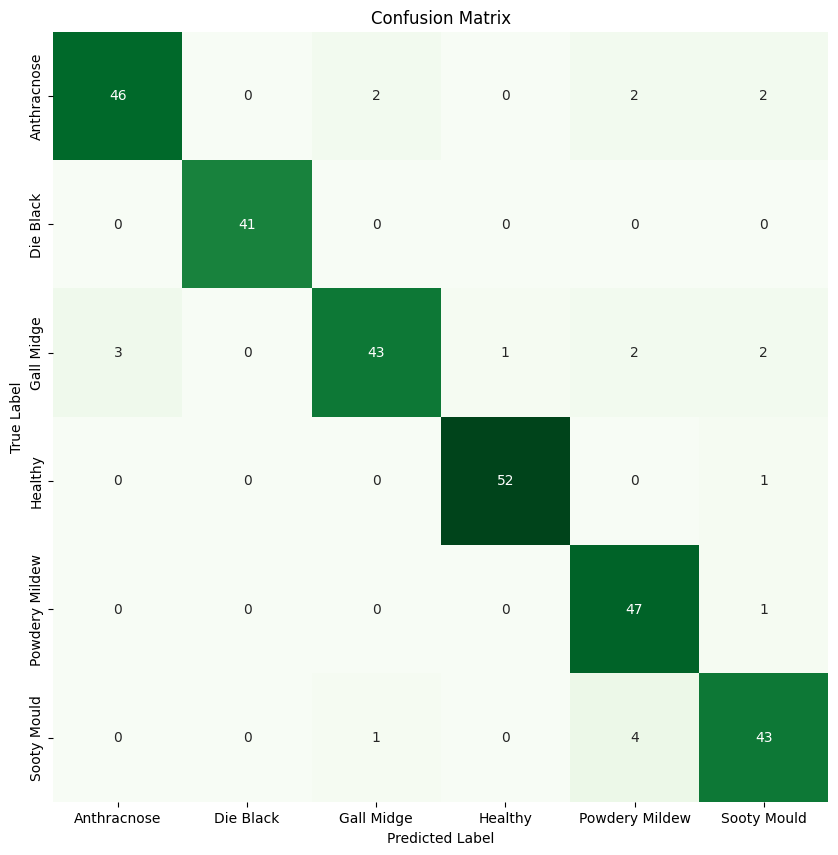

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes)
plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes)

plt.show()
